In [30]:
%pylab inline
import os
import gc
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTable
import catutil as utilities
inDir='./wrkDir/database/s19-COSMOS/origin/'
outDir='./wrkDir/database/s19-COSMOS/origin/%s-nside512/'
hpfname='./wrkDir/database/s19a_fdfc_hp_contarea_izy-gt-5_trimmed_fd001.fits'

Populating the interactive namespace from numpy and matplotlib


0.2157373249795569 0.1590758303766786


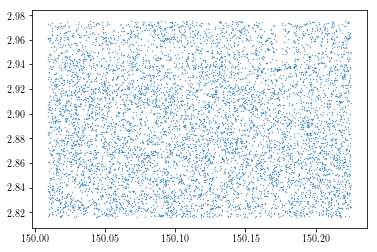

In [14]:
nside   =   512
# Split into healpix with nside=512
snList=['BEST','MEDIAN','WORST']
for ssname in snList[2:]:
    fname=os.path.join(inDir,'COSMOS_WIDE_DEPTH_%s.fits' %ssname)
    data=pyfits.getdata(fname)
    ra,dec  =   utilities.get_radec(data)
    # Get flag
    mfactor =   np.pi/180.
    phi     =   ra*mfactor
    theta   =   np.pi/2. - dec*mfactor
    hpinds  =   hp.ang2pix(nside, theta, phi, nest = True)
    hpSet   =   np.unique(hpinds)
    for pixId in hpSet:
        vec=hp.boundaries(nside=nside,pix=pixId,nest=True).T
        raBs,decBs=hp.vec2ang(vec,lonlat=True)
        raMax=raBs.max()+0.02
        decMax=decBs.max()+0.02
        raMin=raBs.min()-0.02
        decMin=decBs.min()-0.02
        raC=(raMin+raMax)/2.
        decC=(decMin+decMax)/2.
        mask2=(ra>raMin)&(ra<raMax)&(dec>decMin)&(dec<decMax)
        mask=(hpinds==pixId)
        if np.sum(mask)>100:
            outfname=os.path.join(outDir %ssname,'%d.fits' %pixId)
            pyfits.writeto(outfname,data[mask2],overwrite=True)
    del data,mask,mask2
    gc.collect()

pixId=hpSet[-10]
outfname=os.path.join(outDir %ssname,'%d.fits' %pixId)
a=pyfits.getdata(outfname)
ra,dec=utilities.get_radec(a)
plt.close()
plt.scatter(ra,dec,s=0.1)
print(ra.max()-ra.min(),dec.max()-dec.min())

In [25]:
import numpy as np
import healpy as hp
import fitsio
nside=512
npix=hp.nside2npix(nside)
pixAll=np.arange(npix)
vec=hp.boundaries(nside=nside,pix=pixAll,nest=True)
vec=np.swapaxes(vec,1,2)
raBs,decBs=hp.vec2ang(vec,lonlat=True)
raBs[raBs<1e-6]=360.

raBs=raBs.reshape((npix,4))
decBs=decBs.reshape((npix,4))
# neglect data from poles
mask=(decBs[:,0]<85)&(decBs[:,2]>-85)
raBs=raBs[mask]
decBs=decBs[mask]
pixAll=pixAll[mask]
# the healpix cross ra=0.
maskMax=np.abs(raBs[:,3]-np.max(raBs,axis=1))>1e-3
raBs[:,3][maskMax]=raBs[:,3][maskMax]+360.
# maximum and minimum
raMax=raBs[:,3]+0.02;raMin=raBs[:,1]-0.02

decMax=decBs[:,0]+0.02;decMin=decBs[:,2]-0.02
raC=(raMin+raMax)/2.
decC=(decMin+decMax)/2.
dra=raMax-raMin;ddec=decMax-decMin

types=[('pix','i4'),('raMin','>f8'),('raMax','>f8'),('decMin','>f8'),('decMax','>f8'),('dra','>f8'),('ddec','>f8')]
data=np.stack([pixAll,raMin,raMax,decMin,decMax,dra,ddec]).T
data=[tuple(ii) for ii in data]
out=np.array(data,dtype=types)
fitsio.write('/work/xiangchong.li/work/skyMap/healpix-nside%d-nest.fits' %nside,out)

In [26]:
import galsim
import fitsio
import healpy as hp
import imgSimutil as hscimgUtil

nside=512
hpInfo=fitsio.read(hscimgUtil.hpInfofname %nside)

cosmo252=hscimgUtil.cosmoHSTGal('252')
ra=cosmo252.catused['ra']
dec=cosmo252.catused['dec']
indAll  =   cosmo252.catused['index']

array([0.34425648, 0.74100276, 1.11204963, 2.13298328])

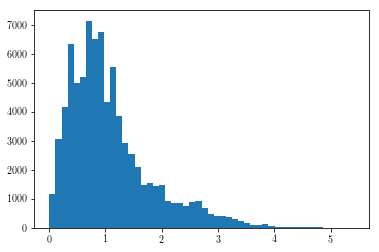

In [36]:
plt.close()
plt.hist(cosmo252.catused['zphot'],bins=50)
bins=np.percentile(cosmo252.catused['zphot'],[0.,25,50,75,100])
a=np.histogram(cosmo252.catused['zphot'],bins=bins,weights=cosmo252.catused['zphot'])[0]
b=np.histogram(cosmo252.catused['zphot'],bins=bins)[0]
a/b

2430


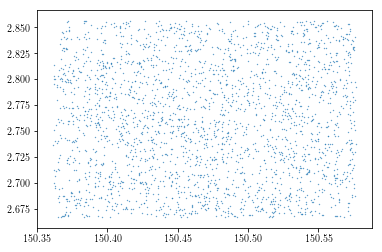

In [3]:
pixId=hscimgUtil.cosmoHSThpix[-10]
data=cosmo252.selectHpix(pixId)
print(len(data))
plt.close()
plt.scatter(data['ra'],data['dec'],s=0.1)

In [25]:
from pixel3D import cartesianGrid3D
from configparser import ConfigParser
import numpy.lib.recfunctions as rfn

parser  =   ConfigParser()
configName='./wrkDir/s19/s19-cosmos/config-nl1.ini'
parser.read(configName)
gridInfo=   cartesianGrid3D(parser)
# prepare healPIX inds
for pixId in hscimgUtil.cosmoHSThpix:
    # setup projected plane
    dd =  hpInfo[hpInfo['pix']==pixId]
    nx =  int(dd['dra']/gridInfo.delta)
    ny =  int(dd['ddec']/gridInfo.delta)
    gridInfo.setupNaivePlane(nx,ny,dd['raMin'],dd['decMin'])
    
    catPix=cosmo252.selectHpix(pixId)
    x,y=  gridInfo.project_tan(catPix['ra'],catPix['dec'],pix=True)
    xI =  np.int_(x+0.5)
    yI =  np.int_(y+0.5)
    np.random.seed(pixId)
    dx =  np.random.rand(len(x))-0.5
    dy =  np.random.rand(len(y))-0.5
    types=[('xI','i4'),('yI','i4'),('dx','>f8'),('dy','>f8')]
    data= np.stack([xI,yI,dx,dy]).T
    data= [tuple(ii) for ii in data]
    catOut=np.array(data,dtype=types)
    catOut=   rfn.merge_arrays([catPix,catOut], flatten = True, usemask = False)
    
    ofname  =   os.path.join(cosmo252.hpDir,'cat-%d-25.2.fits' %pixId)
    fitsio.write(ofname,catOut,clobber=True)
    del catPix,catOut,data
    gc.collect()